<a href="https://colab.research.google.com/github/mauricioyc/ngcf_pytorch_g61/blob/master/Neural_Graph_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from time import time
from datetime import datetime
import torch
import os
import sys

# drive path to the project
source_path = "drive/MyDrive/Machine Learning/git/ngcf_pytorch_g61"
sys.path.insert(0,source_path)

# torch cuda initialization
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

# Introduction

Neural Graph Collaborative Filtering (NGCF), created by [Wang et al.(2019)] (https://arxiv.org/abs/1905.08108), is a Deep Learning Recommendation algorithm with graph topology that creates user-item embeddings representation and interactions. In this article we will use [MovieLens: ML-100k dataset](https://grouplens.org/datasets/movielens/100k/) to explore [this](https://github.com/metahexane/ngcf_pytorch_g61) PyTorch implementation of the NGCF.





# Background Information

![imagem](https://drive.google.com/uc?export=view&id=1rAQFHvKvVieAI7pVmfYZPTrHuPxn16n2)

# NGCF

In a traditional collaborative filtering algorithm for ML-100k, the user-item interaction can be represented by a sparse matrix $R_{n,m}$ of liked/watched movies, where $n$ is the number of users and $m$ the movies. This matrix can be factored into two feature matrices in the form
$R_{n,m} = U_{n,f} \times I_{f,m}$, where $f$ is the feature vector size as shown in the figure 2. We can call these factors **Embeddings**.

<br>
<center><img src="https://drive.google.com/uc?export=view&id=1uBb6pFf12tU6l29YPMBb_2YCX-T4SBbY" height="300"><figcaption>Figure 2: Matrix factorization of $R_{n,m} = U_{n,f} \times I_{f,m}$.</figcaption></center>
</br>

In the NGCF, the user-item relationship can be interpreted as a bipartite graph, shown in figure 3, in which node $u_i$ and $i_i$ is a unique user and movie embedding, respectively, and the edge represents the movies each user has seen. The graph can be created from the sparce matrix $R_{n,m}$.

<br>
<center><img src="https://drive.google.com/uc?export=view&id=1GO5fqKaC_gRnijLjjff1nvtv4X--wMIw" ><figcaption>Figure 3: User-item bipartite graph.</figcaption></center>
</br>

In the paper, the NGCF propagates the messages from the user-item embeddings relationship over the the bipartate graph, being able to capture neighbors information depending on the connectivity order parameterized. For example, a 2nd-oder connectivity can capture the path $u1 \leftarrow i2 \leftarrow u2$ and a 3rd-order connectivity send information to $u1$ through the path $u1 \leftarrow i2 \leftarrow u2 \leftarrow i3$, being able to capture the fact that user 1 might like movie 3.

## 1: NGCF Architecture and Message Propagation

The NGCF is composed by an user and item Embeddings Layer, followed by an Embedding Propagation Layer, that receives the embeddings and calculates an recurrent update of these embeddings, and a final Prediction Layer that calculates the final prediction for a item-user pair. The layers are explained in the following.

<br>
<center><img src="https://drive.google.com/uc?export=view&id=1C4XBYjHCQAcNYFpyT73gvsjoWWWjabaS" height="400"><figcaption>Figure 4: NGCF architecture.</figcaption></center>
</br>

### 1.1: Embedding Layer

The initial user and item embeddings are concatenated in an embedding lookup table as shown in the equation below. This embedding table is initialized using the user and item embeddings with a xavier uniform and will be optimized in an end-to-end fashion by the network.

<br>
<center>$E = [user\_embeddings \space , \space item\_embeddings] = [e_{u_1},...,e_{u_n} \space , \space e_{i_1},...,e_{i_m}]$ </center>
</br>

```python
# initialize weights
def _init_weights(self):
    print("Initializing weights...")
    weight_dict = nn.ParameterDict()

    initializer = torch.nn.init.xavier_uniform_
    
    weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(device)))
    weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(device)))

# ... omitted code

# creating E
def forward(self, u, i, j):
  # ... omitted code
  ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)
  # ... omitted code
```

### 1.2: Embedding Propagation Layers

The Embedding Propagation Layers receives the user-item embbedings, as well as the graph connectivety to construct the message. The message takes into consideration the current embedding state of $e_u^{0}$ and $e_i^{0}$ and updates in a recurrent form the respective embedding. In each step $l$, a $e_u^{l}$ and $e_i^{l}$ is created and concatenated to form the final features to the Predict Layer.

#### 1.2.2: Message Definition:

<center>
$\begin{equation}
  \begin{cases}
      m^{(l)}_{u \space \leftarrow \space i}  = \frac{1}{\sqrt{|\mathcal{N}_u||\mathcal{N}_i|}}\left(W^{(l)}_1e^{(l-1)}_i + W^{(l)}_2(e^{(l-1)}_i \space \odot \space e^{(l-1)}_u)\right)  \\
      m^{(l)}_{u \space \leftarrow \space u}  = W^{(l)}_1e^{(l-1)}_u \\
    \end{cases}       
\end{equation}$
<br></br>
</center>



#### 1.2.1: Message Aggregation

<center>
$e^{(l)}_{u} = \text{LeakyReLU}(m^{(l)}_{u \space \leftarrow \space u} + \sum_{i \space \in \space \mathcal{N}_u} m^{(l)}_{u \space \leftarrow \space i})$
</center>
<br></br>

#### 1.2.3: Matrix Form:

<center>
$E^{(l)} = \text{LeakyReLU}\left((\mathcal{L} + I)E^{(l-1)}W^{(l)}_1 + \mathcal{L}E^{(l-1)} \space \odot \space E^{(l-1)}W^{(l)}_2\right)$
</center>

<br></br>
where $\mathcal{L}$ represents the Laplacian for the user-item graph, which is formulated as:
 
<center>
$\mathcal{L} = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$ and 
$A = \begin{equation}
  \begin{bmatrix}
      0&R \\
      R^T&0 
    \end{bmatrix}       
\end{equation}$
</center>

<br></br>
In the code, first we inicialize the $A$ and $\mathcal{L}$ from the train set. 

```python
# Creating A = (L + I), where R = Train_Dok_matrix
adj_mat[:self.n_users, self.n_users:] = R
adj_mat[self.n_users:, :self.n_users] = R.T

# normalize adjacency matrix
def normalized_adj_single(adj):
    rowsum = np.array(adj.sum(1))

    d_inv = np.power(rowsum, -.5).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat_inv = sp.diags(d_inv)

    norm_adj = d_mat_inv.dot(adj).dot(d_mat_inv)
    return norm_adj.tocoo()
adj_mtx = normalized_adj_single(adj_mat) + sp.eye(adj_mat.shape[0])

# from A, create L = (A - I)
self.adj_mtx = adj_mtx
self.laplacian = adj_mtx - sp.eye(adj_mtx.shape[0])

# Create Matrix 'A', PyTorch sparse tensor of SP adjacency_mtx
self.A = self._convert_sp_mat_to_sp_tensor(self.adj_mtx)
self.L = self._convert_sp_mat_to_sp_tensor(self.laplacian)

# apply drop-out mask
A_hat = self._droupout_sparse(self.A) if self.node_dropout > 0 else self.A
L_hat = self._droupout_sparse(self.L) if self.node_dropout > 0 else self.L
```

Then, using the first embedding layer created $e^0$, a recurrent propagation calculates the following embeddings with message information $e^l_u$ and $e^l_i$, where:

<center>
$\text{side_embeddings} = (\mathcal{L} + I)E^{(l-1)}W^{(l)}_1$

$\text{side_L_embeddings} = \mathcal{L}E^{(l-1)} \space \odot \space E^{(l-1)}W^{(l)}_2$
</center>

```python
# forward pass for 'n' propagation layers
for k in range(self.n_layers):
    # weighted sum messages of neighbours
    side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)
    side_L_embeddings = torch.sparse.mm(L_hat, ego_embeddings)

    # transformed sum weighted sum messages of neighbours
    sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) + self.weight_dict['b_gc_%d' % k]

    # bi messages of neighbours
    bi_embeddings = torch.mul(ego_embeddings, side_L_embeddings)
    # transformed bi messages of neighbours
    bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) + self.weight_dict['b_bi_%d' % k]

    # non-linear activation 
    ego_embeddings = F.leaky_relu(sum_embeddings + bi_embeddings)
    # + message dropout
    mess_dropout_mask = nn.Dropout(self.mess_dropout)
    ego_embeddings = mess_dropout_mask(ego_embeddings)

    # normalize activation
    norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)

    all_embeddings.append(norm_embeddings)
```

### 1.3: Prediction Layer

The model prediction calculates the multiplication of $e^*_u$ by $e^*_i$, which is the logits of the user $u$ to see the movie $i$. 

<center>
$\hat{y}_{NGCF} = e^{* \top}_u e^*_i, \space$ where $\space e^*_u = e^{(0)}_u || \space .... \space || e^{(L)}_u \space \text{and} \space \space e^*_i = e^{(0)}_i || \space .... \space || e^{(L)}_i$
</center>

```python
all_embeddings = torch.cat(all_embeddings, 1)

# back to user/item dimension
u_g_embeddings, i_g_embeddings = all_embeddings.split([self.n_users, self.n_items], 0)

# back to user/item dimension
u_g_embeddings, i_g_embeddings = all_embeddings.split([self.n_users, self.n_items], 0)

self.u_g_embeddings = nn.Parameter(u_g_embeddings)
self.i_g_embeddings = nn.Parameter(i_g_embeddings)

u_emb = u_g_embeddings[u] # user embeddings
p_emb = i_g_embeddings[i] # positive item embeddings
n_emb = i_g_embeddings[j] # negative item embeddings

y_ui = torch.mul(u_emb, p_emb).sum(dim=1)
y_uj = torch.mul(u_emb, n_emb).sum(dim=1)
```

### 1.4: BRP Loss

Bayesian Personalized Ranking (BRP) use item pairs as training data and optimize for correctly ranking item pairs. Our goal is to provide user  u  with a personalized ranking, denoted by $>_u$. If the user has interacted with item i, i.e. $(u,i) \in S$, then we assume that the user prefers this item over all other non-observed items. E.g. in the figure below user $u1$ has interacted with item $i2$ but not item $i_1$, so we assume that this user prefers item $i_2$ over $i_1 :  i_2>_ui_1$. It can be denoted generally as  $i>_uj$ , where the i stands for the positive item and j is for the negative item. For items that the user have both interacted with, we cannot infer any preference. The same is true for two items that a user has not interacted yet (e.g. item $i_1$  and $i_4$ for user $u_1$).

<br>
<center><img src="https://drive.google.com/uc?export=view&id=1zZLneJ25J9yekc1DpVOkTRHlIm5pp9KY" height="300"><figcaption>Figure 5: User-item interaction.</figcaption></center>
</br>

Given these information, we can now get to the Bayesian part of this method. Let $\Theta$ be the parameter of the model that determines the personalized ranking. BPR's goal is to maximize the posterior probability:

<center>
$p(\Theta|i>_uj)∝p(i>uj|\Theta)p(\Theta)$
</center>

$p(i>_uj | \Theta)$ is the likelihood function, it captures the individual probability that a user really prefers item i over item j. We compute this probability with the form:

<center>
$p(i>_uj|\Theta) = \sigma \left( \hat r_{uij}(\Theta) \right)$
</center>

 
Where: $\sigma$ is the good old logistic sigmoid:

<center>
$ \sigma(x) = \frac{1}{1+e^{-x}}$
</center>
 
And $r_{uij}(\Theta)$ captures the relationship between user $u$, item $i$ and item $j$, which can be further decomposed into:

<center>
$\hat r_{uij}= \hat r_{ui}− \hat r_{uj}$
</center>

In order to complete the Bayesian modeling approach of the personalized ranking task, a general prior density $p(\Theta)$ which is a normal distribution with zero mean and variance-covariance matrix $\sum(\Theta)$, to reduce the number of unknown hyperparameters, we set: $\sum(\Theta) = \lambda_\Theta I$

To sum it all up, the full form of the maximum posterior probability optimization (called BPR-Opt in the paper) can be specified as:

<br>
<center><img src="https://drive.google.com/uc?export=view&id=1YiiUFSzdx4477iuyXnYMXOuGJIBZxxcn" height="300"><figcaption>Figure 6: BRP maximum posterior probability optimization.</figcaption></center>
</br>

where $x_u$ is the user embeddings, $y_i$ the positive item embedding, $y_j$ the negative item embedding and $\lambda_\Theta$ the regularization parameter.

```python
log_prob = (torch.log(torch.sigmoid(y_ui-y_uj))).mean()

# compute bpr-loss
bpr_loss = -log_prob
if self.reg > 0.:
    l2norm = (torch.sum(u_emb**2)/2. + torch.sum(p_emb**2)/2. + torch.sum(n_emb**2)/2.) / u_emb.shape[0]
    l2reg  = self.reg*l2norm
    bpr_loss =  -log_prob + l2reg

return bpr_loss
```

# Coding


### 1: Data Generator

In [ ]:

import random as rd
import scipy.sparse as sp
import numpy as np
[]
class Data(object):
    def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size

        train_file = path + '/train.txt'
        test_file = path + '/test.txt'

        #get number of users and items
        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.neg_pools = {}

        self.exist_users = []

        # search train_file for max user_id/item_id
        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    items = [int(i) for i in l[1:]]
                    # first element is the user_id, rest are items
                    uid = int(l[0])
                    self.exist_users.append(uid)
                    # item/user with highest number is number of items/users
                    self.n_items = max(self.n_items, max(items))
                    self.n_users = max(self.n_users, uid)
                    # number of interactions
                    self.n_train += len(items)

        # search test_file for max item_id
        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')[1:]]
                    except Exception:
                        continue
                    if not items:
                        print("empyt test exists")
                        pass
                    else:
                        self.n_items = max(self.n_items, max(items))
                        self.n_test += len(items)
        # adjust counters: user_id/item_id starts at 0
        self.n_items += 1
        self.n_users += 1

        self.print_statistics()

        # create interactions/ratings matrix 'R' # dok = dictionary of keys
        print('Creating interaction matrices R_train and R_test...')
        t1 = time()
        self.R_train = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32) 
        self.R_test = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)

        self.train_items, self.test_set = {}, {}
        with open(train_file) as f_train:
            with open(test_file) as f_test:
                for l in f_train.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    items = [int(i) for i in l.split(' ')]
                    uid, train_items = items[0], items[1:]
                    # enter 1 if user interacted with item
                    for i in train_items:
                        self.R_train[uid, i] = 1.
                    self.train_items[uid] = train_items

                for l in f_test.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')]
                    except Exception:
                        continue
                    uid, test_items = items[0], items[1:]
                    for i in test_items:
                        self.R_test[uid, i] = 1.0
                    self.test_set[uid] = test_items
        print('Complete. Interaction matrices R_train and R_test created in', time() - t1, 'sec')

    # if exist, get adjacency matrix
    def get_adj_mat(self):
        try:
            t1 = time()
            adj_mat = sp.load_npz(self.path + '/s_adj_mat.npz')
            print('Loaded adjacency-matrix (shape:', adj_mat.shape,') in', time() - t1, 'sec.')

        except Exception:
            print('Creating adjacency-matrix...')
            adj_mat = self.create_adj_mat()
            sp.save_npz(self.path + '/s_adj_mat.npz', adj_mat)
        return adj_mat
    
    # create adjancency matrix
    def create_adj_mat(self):
        t1 = time()
        
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = self.R_train.tolil() # to list of lists

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()
        print('Complete. Adjacency-matrix created in', adj_mat.shape, time() - t1, 'sec.')

        t2 = time()

        # normalize adjacency matrix
        def normalized_adj_single(adj):
            rowsum = np.array(adj.sum(1))

            d_inv = np.power(rowsum, -.5).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)

            norm_adj = d_mat_inv.dot(adj).dot(d_mat_inv)
            return norm_adj.tocoo()

        print('Transforming adjacency-matrix to NGCF-adjacency matrix...')
        ngcf_adj_mat = normalized_adj_single(adj_mat) + sp.eye(adj_mat.shape[0])

        print('Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in', time() - t2, 'sec.')
        return ngcf_adj_mat.tocsr()

    # create collections of N items that users never interacted with
    def negative_pool(self):
        t1 = time()
        for u in self.train_items.keys():
            neg_items = list(set(range(self.n_items)) - set(self.train_items[u]))
            pools = [rd.choice(neg_items) for _ in range(100)]
            self.neg_pools[u] = pools
        print('refresh negative pools', time() - t1)

    # sample data for mini-batches
    def sample(self):
        if self.batch_size <= self.n_users:
            users = rd.sample(self.exist_users, self.batch_size)
        else:
            users = [rd.choice(self.exist_users) for _ in range(self.batch_size)]

        def sample_pos_items_for_u(u, num):
            pos_items = self.train_items[u]
            n_pos_items = len(pos_items)
            pos_batch = []
            while True:
                if len(pos_batch) == num: break
                pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
                pos_i_id = pos_items[pos_id]

                if pos_i_id not in pos_batch:
                    pos_batch.append(pos_i_id)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            neg_items = []
            while True:
                if len(neg_items) == num: break
                neg_id = np.random.randint(low=0, high=self.n_items,size=1)[0]
                if neg_id not in self.train_items[u] and neg_id not in neg_items:
                    neg_items.append(neg_id)
            return neg_items

        def sample_neg_items_for_u_from_pools(u, num):
            neg_items = list(set(self.neg_pools[u]) - set(self.train_items[u]))
            return rd.sample(neg_items, num)

        pos_items, neg_items = [], []
        for u in users:
            pos_items += sample_pos_items_for_u(u, 1)
            neg_items += sample_neg_items_for_u(u, 1)

        return users, pos_items, neg_items

    def get_num_users_items(self):
        return self.n_users, self.n_items

    def print_statistics(self):
        print('n_users=%d, n_items=%d' % (self.n_users, self.n_items))
        print('n_interactions=%d' % (self.n_train + self.n_test))
        print('n_train=%d, n_test=%d, sparsity=%.5f' % (self.n_train, self.n_test, (self.n_train + self.n_test)/(self.n_users * self.n_items)))


## 2: Model

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
import scipy.sparse as sp

from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NGCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, layers, reg, node_dropout, mess_dropout,
        adj_mtx):
        super().__init__()

        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.adj_mtx = adj_mtx
        self.laplacian = adj_mtx - sp.eye(adj_mtx.shape[0])
        self.reg = reg
        self.layers = layers
        self.n_layers = len(self.layers)
        self.node_dropout = node_dropout
        self.mess_dropout = mess_dropout

        #self.u_g_embeddings = nn.Parameter(torch.empty(n_users, emb_dim+np.sum(self.layers)))
        #self.i_g_embeddings = nn.Parameter(torch.empty(n_items, emb_dim+np.sum(self.layers)))

        # Initialize weights
        self.weight_dict = self._init_weights()
        print("Weights initialized.")

        # Create Matrix 'A', PyTorch sparse tensor of SP adjacency_mtx
        self.A = self._convert_sp_mat_to_sp_tensor(self.adj_mtx)
        self.L = self._convert_sp_mat_to_sp_tensor(self.laplacian)

    # initialize weights
    def _init_weights(self):
        print("Initializing weights...")
        weight_dict = nn.ParameterDict()

        initializer = torch.nn.init.xavier_uniform_
        
        weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(device)))
        weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(device)))

        weight_size_list = [self.emb_dim] + self.layers

        for k in range(self.n_layers):
            weight_dict['W_gc_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_gc_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
            
            weight_dict['W_bi_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_bi_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
           
        return weight_dict

    # convert sparse matrix into sparse PyTorch tensor
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix

        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res

    # apply node_dropout
    def _droupout_sparse(self, X):
        """
        Drop individual locations in X
        
        Arguments:
        ---------
        X = adjacency matrix (PyTorch sparse tensor)
        dropout = fraction of nodes to drop
        noise_shape = number of non non-zero entries of X
        """
        
        node_dropout_mask = ((self.node_dropout) + torch.rand(X._nnz())).floor().bool().to(device)
        i = X.coalesce().indices()
        v = X.coalesce()._values()
        i[:,node_dropout_mask] = 0
        v[node_dropout_mask] = 0
        X_dropout = torch.sparse.FloatTensor(i, v, X.shape).to(X.device)

        return  X_dropout.mul(1/(1-self.node_dropout))

    def forward(self, u, i, j):
        """
        Computes the forward pass
        
        Arguments:
        ---------
        u = user
        i = positive item (user interacted with item)
        j = negative item (user did not interact with item)
        """
        # apply drop-out mask
        A_hat = self._droupout_sparse(self.A) if self.node_dropout > 0 else self.A
        L_hat = self._droupout_sparse(self.L) if self.node_dropout > 0 else self.L

        ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)

        all_embeddings = [ego_embeddings]

        # forward pass for 'n' propagation layers
        for k in range(self.n_layers):

            # weighted sum messages of neighbours
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)
            side_L_embeddings = torch.sparse.mm(L_hat, ego_embeddings)

            # transformed sum weighted sum messages of neighbours
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) + self.weight_dict['b_gc_%d' % k]

            # bi messages of neighbours
            bi_embeddings = torch.mul(ego_embeddings, side_L_embeddings)
            # transformed bi messages of neighbours
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) + self.weight_dict['b_bi_%d' % k]

            # non-linear activation 
            ego_embeddings = F.leaky_relu(sum_embeddings + bi_embeddings)
            # + message dropout
            mess_dropout_mask = nn.Dropout(self.mess_dropout)
            ego_embeddings = mess_dropout_mask(ego_embeddings)

            # normalize activation
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)

            all_embeddings.append(norm_embeddings)

        all_embeddings = torch.cat(all_embeddings, 1)
        
        # back to user/item dimension
        u_g_embeddings, i_g_embeddings = all_embeddings.split([self.n_users, self.n_items], 0)

        self.u_g_embeddings = nn.Parameter(u_g_embeddings)
        self.i_g_embeddings = nn.Parameter(i_g_embeddings)
        
        u_emb = u_g_embeddings[u] # user embeddings
        p_emb = i_g_embeddings[i] # positive item embeddings
        n_emb = i_g_embeddings[j] # negative item embeddings

        y_ui = torch.mul(u_emb, p_emb).sum(dim=1)
        y_uj = torch.mul(u_emb, n_emb).sum(dim=1)
        log_prob = (torch.log(torch.sigmoid(y_ui-y_uj))).mean()

        # compute bpr-loss
        bpr_loss = -log_prob
        if self.reg > 0.:
            l2norm = (torch.sum(u_emb**2)/2. + torch.sum(p_emb**2)/2. + torch.sum(n_emb**2)/2.) / u_emb.shape[0]
            l2reg  = self.reg*l2norm
            bpr_loss =  -log_prob + l2reg

        return bpr_loss

## 3: Utils

In [ ]:
import numpy as np
import torch

def early_stopping(log_value, best_value, stopping_step, flag_step, expected_order='asc'):
    """
    Check if early_stopping is needed
    Function copied from original code
    """
    assert expected_order in ['asc', 'des']
    if (expected_order == 'asc' and log_value >= best_value) or (expected_order == 'des' and log_value <= best_value):
        stopping_step = 0
        best_value = log_value
    else:
        stopping_step += 1

    if stopping_step >= flag_step:
        print("Early stopping at step: {} log:{}".format(flag_step, log_value))
        should_stop = True
    else:
        should_stop = False

    return best_value, stopping_step, should_stop

def train(model, data_generator, optimizer):
    """
    Train the model PyTorch style

    Arguments:
    ---------
    model: PyTorch model
    data_generator: Data object
    optimizer: PyTorch optimizer
    """
    model.train()
    n_batch = data_generator.n_train // data_generator.batch_size + 1
    running_loss=0
    for _ in range(n_batch):
        u, i, j = data_generator.sample()
        optimizer.zero_grad()
        loss = model(u,i,j)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss

def split_matrix(X, n_splits=100):
    """
    Split a matrix/Tensor into n_folds (for the user embeddings and the R matrices)

    Arguments:
    ---------
    X: matrix to be split
    n_folds: number of folds

    Returns:
    -------
    splits: split matrices
    """
    splits = []
    chunk_size = X.shape[0] // n_splits
    for i in range(n_splits):
        start = i * chunk_size
        end = X.shape[0] if i == n_splits - 1 else (i + 1) * chunk_size
        splits.append(X[start:end])
    return splits

def compute_ndcg_k(pred_items, test_items, test_indices, k):
    """
    Compute NDCG@k
    
    Arguments:
    ---------
    pred_items: binary tensor with 1s in those locations corresponding to the predicted item interactions
    test_items: binary tensor with 1s in locations corresponding to the real test interactions
    test_indices: tensor with the location of the top-k predicted items
    k: k'th-order 

    Returns:
    -------
    NDCG@k
    """
    r = (test_items * pred_items).gather(1, test_indices)
    f = torch.from_numpy(np.log2(np.arange(2, k+2))).float().cuda()
    dcg = (r[:, :k]/f).sum(1)
    dcg_max = (torch.sort(r, dim=1, descending=True)[0][:, :k]/f).sum(1)
    ndcg = dcg/dcg_max
    ndcg[torch.isnan(ndcg)] = 0
    return ndcg


def eval_model(u_emb, i_emb, Rtr, Rte, k):
    """
    Evaluate the model
    
    Arguments:
    ---------
    u_emb: User embeddings
    i_emb: Item embeddings
    Rtr: Sparse matrix with the training interactions
    Rte: Sparse matrix with the testing interactions
    k : kth-order for metrics
    
    Returns:
    --------
    result: Dictionary with lists correponding to the metrics at order k for k in Ks
    """
    # split matrices
    ue_splits = split_matrix(u_emb)
    tr_splits = split_matrix(Rtr)
    te_splits = split_matrix(Rte)

    recall_k, ndcg_k= [], []
    # compute results for split matrices
    for ue_f, tr_f, te_f in zip(ue_splits, tr_splits, te_splits):

        scores = torch.mm(ue_f, i_emb.t())

        test_items = torch.from_numpy(te_f.todense()).float().cuda()
        non_train_items = torch.from_numpy(1-(tr_f.todense())).float().cuda()
        scores = scores * non_train_items

        _, test_indices = torch.topk(scores, dim=1, k=k)
        pred_items = torch.zeros_like(scores).float()
        pred_items.scatter_(dim=1,index=test_indices,value=torch.tensor(1.0).cuda())

        topk_preds = torch.zeros_like(scores).float()
        topk_preds.scatter_(dim=1,index=test_indices[:, :k],value=torch.tensor(1.0))

        TP = (test_items * topk_preds).sum(1)
        rec = TP/test_items.sum(1)
        ndcg = compute_ndcg_k(pred_items, test_items, test_indices, k)

        recall_k.append(rec)
        ndcg_k.append(ndcg)

    return torch.cat(recall_k).mean(), torch.cat(ndcg_k).mean()

## 4: Parameter and Base Initialization

In [ ]:
# Parameters Inicialization

data_dir = source_path+'/data/'
dataset = 'ml-100k'
batch_size = 1024
layers = eval('[64,64]')
emb_dim = 64
lr = 0.0001
reg = 1e-5
mess_dropout = 0.1
node_dropout = 0.
k = 10
n_epochs = 400
eval_N = 1
save_results = 1
results_dir = 'results'

In [ ]:
data_generator = Data(path=data_dir + dataset, batch_size=batch_size)
adj_mtx = data_generator.get_adj_mat()

model = NGCF(data_generator.n_users, 
              data_generator.n_items,
              emb_dim,
              layers,
              reg,
              node_dropout,
              mess_dropout,
              adj_mtx)

n_users=943, n_items=1682
n_interactions=100000
n_train=80064, n_test=19936, sparsity=0.06305
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 1.0580151081085205 sec
Loaded adjacency-matrix (shape: (2625, 2625) ) in 0.01728987693786621 sec.
Initializing weights...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Weights initialized.


## 5: Training

In [8]:
if use_cuda:
    model = model.cuda()

# current best metric
cur_best_metric = 0

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Set values for early stopping
cur_best_loss, stopping_step, should_stop = 1e3, 0, False
today = datetime.now()

print("Start at " + str(today))
print("Using " + str(device) + " for computations")
print("Params on CUDA: " + str(next(model.parameters()).is_cuda))

results = {"Epoch": [],
            "Loss": [],
            "Recall": [],
            "NDCG": [],
            "Training Time": []}

for epoch in range(n_epochs):

    t1 = time()
    loss = train(model, data_generator, optimizer)
    training_time = time()-t1
    print("Epoch: {}, Training time: {:.2f}s, Loss: {:.4f}".
        format(epoch, training_time, loss))

    # print test evaluation metrics every N epochs (provided by eval_N)
    if epoch % eval_N  == (eval_N - 1):
        with torch.no_grad():
            t2 = time()
            recall, ndcg = eval_model(model.u_g_embeddings.detach(),
                                      model.i_g_embeddings.detach(),
                                      data_generator.R_train,
                                      data_generator.R_test,
                                      k)
        print(
            "Evaluate current model:\n",
            "Epoch: {}, Validation time: {:.2f}s".format(epoch, time()-t2),"\n",
            "Loss: {:.4f}:".format(loss), "\n",
            "Recall@{}: {:.4f}".format(k, recall), "\n",
            "NDCG@{}: {:.4f}".format(k, ndcg)
            )

        cur_best_metric, stopping_step, should_stop = \
        early_stopping(recall, cur_best_metric, stopping_step, flag_step=5)

        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(recall.item())
        results['NDCG'].append(ndcg.item())
        results['Training Time'].append(training_time)
    else:
        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(None)
        results['NDCG'].append(None)
        results['Training Time'].append(training_time)

    if should_stop == True: break

Start at 2021-01-30 22:18:15.919897
Using cuda for computations
Params on CUDA: True


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 0, Training time: 3.97s, Loss: 54.4709
Evaluate current model:
 Epoch: 0, Validation time: 1.12s 
 Loss: 54.4709: 
 Recall@10: 0.0102 
 NDCG@10: 0.1195


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 1, Training time: 3.99s, Loss: 53.9444
Evaluate current model:
 Epoch: 1, Validation time: 1.13s 
 Loss: 53.9444: 
 Recall@10: 0.0114 
 NDCG@10: 0.1164


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 2, Training time: 3.88s, Loss: 52.1963
Evaluate current model:
 Epoch: 2, Validation time: 1.16s 
 Loss: 52.1963: 
 Recall@10: 0.0126 
 NDCG@10: 0.1400


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 3, Training time: 3.88s, Loss: 44.9912
Evaluate current model:
 Epoch: 3, Validation time: 1.12s 
 Loss: 44.9912: 
 Recall@10: 0.0214 
 NDCG@10: 0.1629


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 4, Training time: 3.91s, Loss: 40.4744
Evaluate current model:
 Epoch: 4, Validation time: 1.12s 
 Loss: 40.4744: 
 Recall@10: 0.0220 
 NDCG@10: 0.1558


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 5, Training time: 3.89s, Loss: 39.2227
Evaluate current model:
 Epoch: 5, Validation time: 1.14s 
 Loss: 39.2227: 
 Recall@10: 0.0287 
 NDCG@10: 0.1829


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 6, Training time: 3.90s, Loss: 38.0954
Evaluate current model:
 Epoch: 6, Validation time: 1.12s 
 Loss: 38.0954: 
 Recall@10: 0.0327 
 NDCG@10: 0.1990


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 7, Training time: 3.94s, Loss: 37.1410
Evaluate current model:
 Epoch: 7, Validation time: 1.13s 
 Loss: 37.1410: 
 Recall@10: 0.0364 
 NDCG@10: 0.1997


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 8, Training time: 3.99s, Loss: 35.9227
Evaluate current model:
 Epoch: 8, Validation time: 1.13s 
 Loss: 35.9227: 
 Recall@10: 0.0405 
 NDCG@10: 0.2213


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 9, Training time: 3.95s, Loss: 34.2204
Evaluate current model:
 Epoch: 9, Validation time: 1.13s 
 Loss: 34.2204: 
 Recall@10: 0.0419 
 NDCG@10: 0.2254


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 10, Training time: 3.85s, Loss: 33.0042
Evaluate current model:
 Epoch: 10, Validation time: 1.13s 
 Loss: 33.0042: 
 Recall@10: 0.0473 
 NDCG@10: 0.2478


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 11, Training time: 3.88s, Loss: 31.9640
Evaluate current model:
 Epoch: 11, Validation time: 1.13s 
 Loss: 31.9640: 
 Recall@10: 0.0495 
 NDCG@10: 0.2499


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 12, Training time: 3.92s, Loss: 30.9968
Evaluate current model:
 Epoch: 12, Validation time: 1.12s 
 Loss: 30.9968: 
 Recall@10: 0.0548 
 NDCG@10: 0.2763


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 13, Training time: 3.89s, Loss: 30.5121
Evaluate current model:
 Epoch: 13, Validation time: 1.12s 
 Loss: 30.5121: 
 Recall@10: 0.0508 
 NDCG@10: 0.2623


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 14, Training time: 4.03s, Loss: 29.8741
Evaluate current model:
 Epoch: 14, Validation time: 1.12s 
 Loss: 29.8741: 
 Recall@10: 0.0562 
 NDCG@10: 0.2798


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 15, Training time: 3.90s, Loss: 29.4283
Evaluate current model:
 Epoch: 15, Validation time: 1.13s 
 Loss: 29.4283: 
 Recall@10: 0.0754 
 NDCG@10: 0.3111


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 16, Training time: 3.92s, Loss: 29.2288
Evaluate current model:
 Epoch: 16, Validation time: 1.14s 
 Loss: 29.2288: 
 Recall@10: 0.0577 
 NDCG@10: 0.2877


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 17, Training time: 3.93s, Loss: 28.8312
Evaluate current model:
 Epoch: 17, Validation time: 1.13s 
 Loss: 28.8312: 
 Recall@10: 0.0685 
 NDCG@10: 0.3132


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 18, Training time: 3.89s, Loss: 28.3985
Evaluate current model:
 Epoch: 18, Validation time: 1.13s 
 Loss: 28.3985: 
 Recall@10: 0.0711 
 NDCG@10: 0.3098


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 19, Training time: 3.90s, Loss: 28.3969
Evaluate current model:
 Epoch: 19, Validation time: 1.13s 
 Loss: 28.3969: 
 Recall@10: 0.0681 
 NDCG@10: 0.3083


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 20, Training time: 3.94s, Loss: 28.0841
Evaluate current model:
 Epoch: 20, Validation time: 1.12s 
 Loss: 28.0841: 
 Recall@10: 0.0829 
 NDCG@10: 0.3320


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 21, Training time: 3.90s, Loss: 27.7996
Evaluate current model:
 Epoch: 21, Validation time: 1.16s 
 Loss: 27.7996: 
 Recall@10: 0.0800 
 NDCG@10: 0.3405


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 22, Training time: 3.88s, Loss: 27.5872
Evaluate current model:
 Epoch: 22, Validation time: 1.13s 
 Loss: 27.5872: 
 Recall@10: 0.0812 
 NDCG@10: 0.3484


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 23, Training time: 3.92s, Loss: 27.4615
Evaluate current model:
 Epoch: 23, Validation time: 1.14s 
 Loss: 27.4615: 
 Recall@10: 0.0869 
 NDCG@10: 0.3555


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 24, Training time: 3.94s, Loss: 27.3251
Evaluate current model:
 Epoch: 24, Validation time: 1.14s 
 Loss: 27.3251: 
 Recall@10: 0.0857 
 NDCG@10: 0.3582


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 25, Training time: 3.89s, Loss: 27.1178
Evaluate current model:
 Epoch: 25, Validation time: 1.12s 
 Loss: 27.1178: 
 Recall@10: 0.0888 
 NDCG@10: 0.3724


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 26, Training time: 3.91s, Loss: 26.9648
Evaluate current model:
 Epoch: 26, Validation time: 1.18s 
 Loss: 26.9648: 
 Recall@10: 0.0885 
 NDCG@10: 0.3665


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 27, Training time: 3.90s, Loss: 26.7288
Evaluate current model:
 Epoch: 27, Validation time: 1.16s 
 Loss: 26.7288: 
 Recall@10: 0.0913 
 NDCG@10: 0.3924


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 28, Training time: 3.92s, Loss: 26.1718
Evaluate current model:
 Epoch: 28, Validation time: 1.17s 
 Loss: 26.1718: 
 Recall@10: 0.1035 
 NDCG@10: 0.4031


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 29, Training time: 3.90s, Loss: 25.2988
Evaluate current model:
 Epoch: 29, Validation time: 1.15s 
 Loss: 25.2988: 
 Recall@10: 0.0901 
 NDCG@10: 0.3699


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 30, Training time: 3.90s, Loss: 24.9371
Evaluate current model:
 Epoch: 30, Validation time: 1.15s 
 Loss: 24.9371: 
 Recall@10: 0.0980 
 NDCG@10: 0.4037


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 31, Training time: 3.97s, Loss: 24.5788
Evaluate current model:
 Epoch: 31, Validation time: 1.13s 
 Loss: 24.5788: 
 Recall@10: 0.1028 
 NDCG@10: 0.4037


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 32, Training time: 3.92s, Loss: 24.3998
Evaluate current model:
 Epoch: 32, Validation time: 1.12s 
 Loss: 24.3998: 
 Recall@10: 0.0990 
 NDCG@10: 0.4085


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 33, Training time: 3.89s, Loss: 24.2051
Evaluate current model:
 Epoch: 33, Validation time: 1.12s 
 Loss: 24.2051: 
 Recall@10: 0.1089 
 NDCG@10: 0.4135


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 34, Training time: 3.83s, Loss: 24.1215
Evaluate current model:
 Epoch: 34, Validation time: 1.12s 
 Loss: 24.1215: 
 Recall@10: 0.1068 
 NDCG@10: 0.4162


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 35, Training time: 3.88s, Loss: 23.8894
Evaluate current model:
 Epoch: 35, Validation time: 1.12s 
 Loss: 23.8894: 
 Recall@10: 0.1094 
 NDCG@10: 0.4247


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 36, Training time: 3.92s, Loss: 23.9233
Evaluate current model:
 Epoch: 36, Validation time: 1.13s 
 Loss: 23.9233: 
 Recall@10: 0.1200 
 NDCG@10: 0.4407


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 37, Training time: 3.88s, Loss: 23.5282
Evaluate current model:
 Epoch: 37, Validation time: 1.12s 
 Loss: 23.5282: 
 Recall@10: 0.1194 
 NDCG@10: 0.4371


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 38, Training time: 3.95s, Loss: 23.3035
Evaluate current model:
 Epoch: 38, Validation time: 1.13s 
 Loss: 23.3035: 
 Recall@10: 0.1169 
 NDCG@10: 0.4251


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 39, Training time: 3.92s, Loss: 23.2053
Evaluate current model:
 Epoch: 39, Validation time: 1.13s 
 Loss: 23.2053: 
 Recall@10: 0.1196 
 NDCG@10: 0.4363


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 40, Training time: 3.98s, Loss: 23.1556
Evaluate current model:
 Epoch: 40, Validation time: 1.14s 
 Loss: 23.1556: 
 Recall@10: 0.1181 
 NDCG@10: 0.4311


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 41, Training time: 3.91s, Loss: 22.9151
Evaluate current model:
 Epoch: 41, Validation time: 1.14s 
 Loss: 22.9151: 
 Recall@10: 0.1229 
 NDCG@10: 0.4484


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 42, Training time: 3.91s, Loss: 22.7827
Evaluate current model:
 Epoch: 42, Validation time: 1.12s 
 Loss: 22.7827: 
 Recall@10: 0.1225 
 NDCG@10: 0.4455


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 43, Training time: 3.92s, Loss: 22.6084
Evaluate current model:
 Epoch: 43, Validation time: 1.12s 
 Loss: 22.6084: 
 Recall@10: 0.1229 
 NDCG@10: 0.4519


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 44, Training time: 3.92s, Loss: 22.6739
Evaluate current model:
 Epoch: 44, Validation time: 1.12s 
 Loss: 22.6739: 
 Recall@10: 0.1323 
 NDCG@10: 0.4668


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 45, Training time: 3.89s, Loss: 22.4374
Evaluate current model:
 Epoch: 45, Validation time: 1.13s 
 Loss: 22.4374: 
 Recall@10: 0.1338 
 NDCG@10: 0.4796


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 46, Training time: 3.88s, Loss: 22.3850
Evaluate current model:
 Epoch: 46, Validation time: 1.14s 
 Loss: 22.3850: 
 Recall@10: 0.1364 
 NDCG@10: 0.4864


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 47, Training time: 3.86s, Loss: 22.1950
Evaluate current model:
 Epoch: 47, Validation time: 1.13s 
 Loss: 22.1950: 
 Recall@10: 0.1323 
 NDCG@10: 0.4702


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 48, Training time: 3.93s, Loss: 22.1015
Evaluate current model:
 Epoch: 48, Validation time: 1.13s 
 Loss: 22.1015: 
 Recall@10: 0.1300 
 NDCG@10: 0.4871


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 49, Training time: 3.87s, Loss: 21.9095
Evaluate current model:
 Epoch: 49, Validation time: 1.18s 
 Loss: 21.9095: 
 Recall@10: 0.1338 
 NDCG@10: 0.4821


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 50, Training time: 3.94s, Loss: 22.0073
Evaluate current model:
 Epoch: 50, Validation time: 1.13s 
 Loss: 22.0073: 
 Recall@10: 0.1385 
 NDCG@10: 0.4940


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 51, Training time: 3.97s, Loss: 21.8283
Evaluate current model:
 Epoch: 51, Validation time: 1.15s 
 Loss: 21.8283: 
 Recall@10: 0.1403 
 NDCG@10: 0.4954


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 52, Training time: 3.94s, Loss: 21.6030
Evaluate current model:
 Epoch: 52, Validation time: 1.17s 
 Loss: 21.6030: 
 Recall@10: 0.1384 
 NDCG@10: 0.5047


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 53, Training time: 3.94s, Loss: 21.4712
Evaluate current model:
 Epoch: 53, Validation time: 1.14s 
 Loss: 21.4712: 
 Recall@10: 0.1428 
 NDCG@10: 0.5057


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 54, Training time: 3.93s, Loss: 21.4700
Evaluate current model:
 Epoch: 54, Validation time: 1.14s 
 Loss: 21.4700: 
 Recall@10: 0.1457 
 NDCG@10: 0.5045


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 55, Training time: 3.94s, Loss: 21.4071
Evaluate current model:
 Epoch: 55, Validation time: 1.15s 
 Loss: 21.4071: 
 Recall@10: 0.1403 
 NDCG@10: 0.5064


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 56, Training time: 3.98s, Loss: 21.2567
Evaluate current model:
 Epoch: 56, Validation time: 1.14s 
 Loss: 21.2567: 
 Recall@10: 0.1479 
 NDCG@10: 0.5103


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 57, Training time: 3.93s, Loss: 21.1854
Evaluate current model:
 Epoch: 57, Validation time: 1.14s 
 Loss: 21.1854: 
 Recall@10: 0.1469 
 NDCG@10: 0.5279


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 58, Training time: 3.92s, Loss: 21.0750
Evaluate current model:
 Epoch: 58, Validation time: 1.15s 
 Loss: 21.0750: 
 Recall@10: 0.1491 
 NDCG@10: 0.5140


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 59, Training time: 3.94s, Loss: 20.7745
Evaluate current model:
 Epoch: 59, Validation time: 1.13s 
 Loss: 20.7745: 
 Recall@10: 0.1498 
 NDCG@10: 0.5240


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 60, Training time: 3.90s, Loss: 20.7812
Evaluate current model:
 Epoch: 60, Validation time: 1.13s 
 Loss: 20.7812: 
 Recall@10: 0.1453 
 NDCG@10: 0.5191


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 61, Training time: 3.92s, Loss: 20.8386
Evaluate current model:
 Epoch: 61, Validation time: 1.14s 
 Loss: 20.8386: 
 Recall@10: 0.1543 
 NDCG@10: 0.5394


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 62, Training time: 3.95s, Loss: 20.5829
Evaluate current model:
 Epoch: 62, Validation time: 1.14s 
 Loss: 20.5829: 
 Recall@10: 0.1547 
 NDCG@10: 0.5372


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 63, Training time: 3.91s, Loss: 20.5413
Evaluate current model:
 Epoch: 63, Validation time: 1.13s 
 Loss: 20.5413: 
 Recall@10: 0.1516 
 NDCG@10: 0.5411


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 64, Training time: 3.91s, Loss: 20.5180
Evaluate current model:
 Epoch: 64, Validation time: 1.14s 
 Loss: 20.5180: 
 Recall@10: 0.1523 
 NDCG@10: 0.5345


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 65, Training time: 3.89s, Loss: 20.3166
Evaluate current model:
 Epoch: 65, Validation time: 1.13s 
 Loss: 20.3166: 
 Recall@10: 0.1594 
 NDCG@10: 0.5456


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 66, Training time: 3.93s, Loss: 20.1451
Evaluate current model:
 Epoch: 66, Validation time: 1.14s 
 Loss: 20.1451: 
 Recall@10: 0.1596 
 NDCG@10: 0.5470


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 67, Training time: 3.95s, Loss: 20.2369
Evaluate current model:
 Epoch: 67, Validation time: 1.13s 
 Loss: 20.2369: 
 Recall@10: 0.1590 
 NDCG@10: 0.5541


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 68, Training time: 3.91s, Loss: 19.9427
Evaluate current model:
 Epoch: 68, Validation time: 1.14s 
 Loss: 19.9427: 
 Recall@10: 0.1615 
 NDCG@10: 0.5561


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 69, Training time: 3.97s, Loss: 20.0465
Evaluate current model:
 Epoch: 69, Validation time: 1.14s 
 Loss: 20.0465: 
 Recall@10: 0.1595 
 NDCG@10: 0.5556


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 70, Training time: 3.93s, Loss: 19.8159
Evaluate current model:
 Epoch: 70, Validation time: 1.15s 
 Loss: 19.8159: 
 Recall@10: 0.1656 
 NDCG@10: 0.5617


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 71, Training time: 3.99s, Loss: 19.6988
Evaluate current model:
 Epoch: 71, Validation time: 1.15s 
 Loss: 19.6988: 
 Recall@10: 0.1634 
 NDCG@10: 0.5565


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 72, Training time: 3.97s, Loss: 19.4477
Evaluate current model:
 Epoch: 72, Validation time: 1.17s 
 Loss: 19.4477: 
 Recall@10: 0.1650 
 NDCG@10: 0.5616


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 73, Training time: 3.97s, Loss: 19.4947
Evaluate current model:
 Epoch: 73, Validation time: 1.14s 
 Loss: 19.4947: 
 Recall@10: 0.1605 
 NDCG@10: 0.5648


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 74, Training time: 3.95s, Loss: 19.5004
Evaluate current model:
 Epoch: 74, Validation time: 1.15s 
 Loss: 19.5004: 
 Recall@10: 0.1694 
 NDCG@10: 0.5782


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 75, Training time: 3.88s, Loss: 19.4147
Evaluate current model:
 Epoch: 75, Validation time: 1.14s 
 Loss: 19.4147: 
 Recall@10: 0.1671 
 NDCG@10: 0.5615


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 76, Training time: 3.90s, Loss: 19.4763
Evaluate current model:
 Epoch: 76, Validation time: 1.14s 
 Loss: 19.4763: 
 Recall@10: 0.1694 
 NDCG@10: 0.5679


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 77, Training time: 3.94s, Loss: 19.1112
Evaluate current model:
 Epoch: 77, Validation time: 1.13s 
 Loss: 19.1112: 
 Recall@10: 0.1708 
 NDCG@10: 0.5766


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 78, Training time: 3.89s, Loss: 18.9664
Evaluate current model:
 Epoch: 78, Validation time: 1.13s 
 Loss: 18.9664: 
 Recall@10: 0.1679 
 NDCG@10: 0.5565


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 79, Training time: 3.90s, Loss: 19.0796
Evaluate current model:
 Epoch: 79, Validation time: 1.13s 
 Loss: 19.0796: 
 Recall@10: 0.1707 
 NDCG@10: 0.5755


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 80, Training time: 3.91s, Loss: 18.9042
Evaluate current model:
 Epoch: 80, Validation time: 1.13s 
 Loss: 18.9042: 
 Recall@10: 0.1736 
 NDCG@10: 0.5793


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 81, Training time: 3.96s, Loss: 18.7865
Evaluate current model:
 Epoch: 81, Validation time: 1.13s 
 Loss: 18.7865: 
 Recall@10: 0.1697 
 NDCG@10: 0.5785


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 82, Training time: 3.96s, Loss: 18.8302
Evaluate current model:
 Epoch: 82, Validation time: 1.13s 
 Loss: 18.8302: 
 Recall@10: 0.1747 
 NDCG@10: 0.5770


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 83, Training time: 3.95s, Loss: 18.6503
Evaluate current model:
 Epoch: 83, Validation time: 1.15s 
 Loss: 18.6503: 
 Recall@10: 0.1743 
 NDCG@10: 0.5812


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 84, Training time: 3.95s, Loss: 18.5392
Evaluate current model:
 Epoch: 84, Validation time: 1.14s 
 Loss: 18.5392: 
 Recall@10: 0.1741 
 NDCG@10: 0.5770


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 85, Training time: 3.92s, Loss: 18.4817
Evaluate current model:
 Epoch: 85, Validation time: 1.15s 
 Loss: 18.4817: 
 Recall@10: 0.1774 
 NDCG@10: 0.5909


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 86, Training time: 3.92s, Loss: 18.4259
Evaluate current model:
 Epoch: 86, Validation time: 1.15s 
 Loss: 18.4259: 
 Recall@10: 0.1788 
 NDCG@10: 0.5868


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 87, Training time: 3.96s, Loss: 18.3679
Evaluate current model:
 Epoch: 87, Validation time: 1.15s 
 Loss: 18.3679: 
 Recall@10: 0.1790 
 NDCG@10: 0.5868


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 88, Training time: 4.02s, Loss: 18.1313
Evaluate current model:
 Epoch: 88, Validation time: 1.16s 
 Loss: 18.1313: 
 Recall@10: 0.1764 
 NDCG@10: 0.5886


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 89, Training time: 3.95s, Loss: 18.0929
Evaluate current model:
 Epoch: 89, Validation time: 1.15s 
 Loss: 18.0929: 
 Recall@10: 0.1782 
 NDCG@10: 0.5959


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 90, Training time: 3.92s, Loss: 18.0902
Evaluate current model:
 Epoch: 90, Validation time: 1.14s 
 Loss: 18.0902: 
 Recall@10: 0.1798 
 NDCG@10: 0.5910


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 91, Training time: 3.91s, Loss: 17.8671
Evaluate current model:
 Epoch: 91, Validation time: 1.15s 
 Loss: 17.8671: 
 Recall@10: 0.1817 
 NDCG@10: 0.5927


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 92, Training time: 3.89s, Loss: 17.8510
Evaluate current model:
 Epoch: 92, Validation time: 1.15s 
 Loss: 17.8510: 
 Recall@10: 0.1802 
 NDCG@10: 0.5981


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 93, Training time: 3.97s, Loss: 17.9758
Evaluate current model:
 Epoch: 93, Validation time: 1.14s 
 Loss: 17.9758: 
 Recall@10: 0.1836 
 NDCG@10: 0.6002


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 94, Training time: 3.90s, Loss: 17.7482
Evaluate current model:
 Epoch: 94, Validation time: 1.13s 
 Loss: 17.7482: 
 Recall@10: 0.1771 
 NDCG@10: 0.5989


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 95, Training time: 3.92s, Loss: 17.5470
Evaluate current model:
 Epoch: 95, Validation time: 1.13s 
 Loss: 17.5470: 
 Recall@10: 0.1806 
 NDCG@10: 0.5908


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 96, Training time: 3.94s, Loss: 17.5699
Evaluate current model:
 Epoch: 96, Validation time: 1.14s 
 Loss: 17.5699: 
 Recall@10: 0.1839 
 NDCG@10: 0.6048


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 97, Training time: 3.92s, Loss: 17.6221
Evaluate current model:
 Epoch: 97, Validation time: 1.14s 
 Loss: 17.6221: 
 Recall@10: 0.1814 
 NDCG@10: 0.6053


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 98, Training time: 3.91s, Loss: 17.5650
Evaluate current model:
 Epoch: 98, Validation time: 1.14s 
 Loss: 17.5650: 
 Recall@10: 0.1830 
 NDCG@10: 0.6014


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 99, Training time: 3.95s, Loss: 17.2710
Evaluate current model:
 Epoch: 99, Validation time: 1.14s 
 Loss: 17.2710: 
 Recall@10: 0.1868 
 NDCG@10: 0.6100


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 100, Training time: 3.95s, Loss: 17.3562
Evaluate current model:
 Epoch: 100, Validation time: 1.13s 
 Loss: 17.3562: 
 Recall@10: 0.1843 
 NDCG@10: 0.6053


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 101, Training time: 3.87s, Loss: 17.1746
Evaluate current model:
 Epoch: 101, Validation time: 1.12s 
 Loss: 17.1746: 
 Recall@10: 0.1816 
 NDCG@10: 0.6059


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 102, Training time: 3.98s, Loss: 17.2047
Evaluate current model:
 Epoch: 102, Validation time: 1.14s 
 Loss: 17.2047: 
 Recall@10: 0.1816 
 NDCG@10: 0.6047


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 103, Training time: 3.94s, Loss: 16.9854
Evaluate current model:
 Epoch: 103, Validation time: 1.15s 
 Loss: 16.9854: 
 Recall@10: 0.1860 
 NDCG@10: 0.6074


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 104, Training time: 4.00s, Loss: 16.9988
Evaluate current model:
 Epoch: 104, Validation time: 1.15s 
 Loss: 16.9988: 
 Recall@10: 0.1813 
 NDCG@10: 0.6023
Early stopping at step: 5 log:0.18132254481315613


## 6 Results

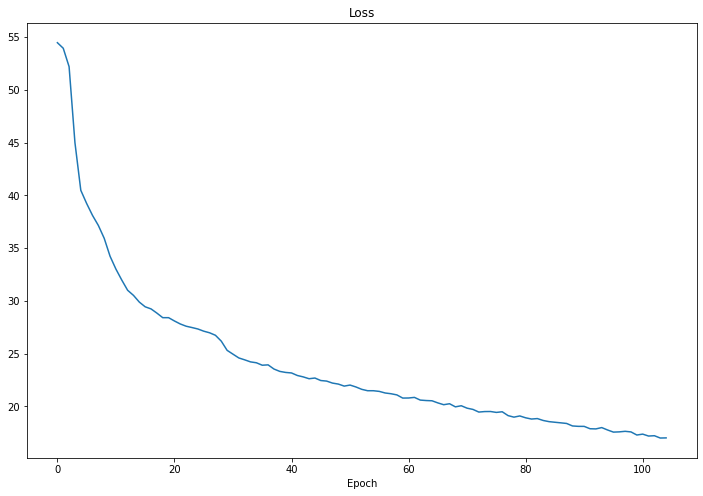

In [10]:
# create model name and save
modelname =  "NGCF" + \
    "_bs_" + str(batch_size) + \
    "_nemb_" + str(emb_dim) + \
    "_layers_" + str(layers) + \
    "_nodedr_" + str(node_dropout) + \
    "_messdr_" + str(mess_dropout) + \
    "_reg_" + str(reg) + \
    "_lr_"  + str(lr)
        
# save
if save_results:
    date = today.strftime("%d%m%Y_%H%M")

    # save model as .pt file
    if os.path.isdir("./models"):
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")
    else:
        os.mkdir("./models")
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")

    # save results as pandas dataframe
    results_df = pd.DataFrame(results)
    results_df.set_index('Epoch', inplace=True)
    if os.path.isdir("./results"):
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    else:
        os.mkdir("./results")
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    # plot loss
    results_df['Loss'].plot(figsize=(12,8), title='Loss')

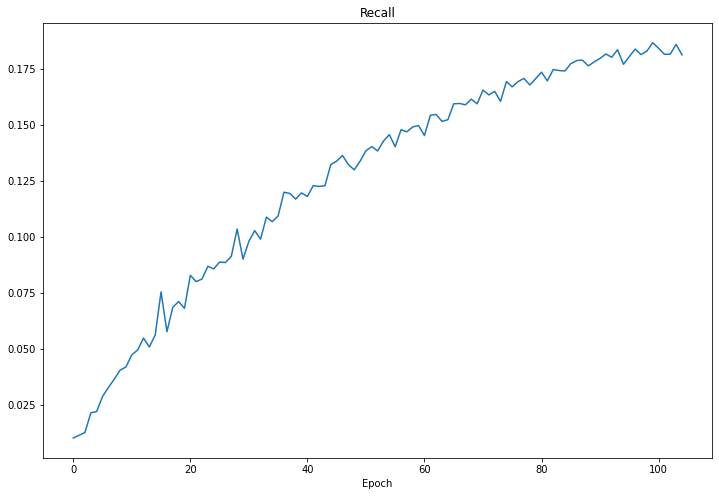

In [19]:
results_df['Recall'].plot(figsize=(12,8), title='Recall')

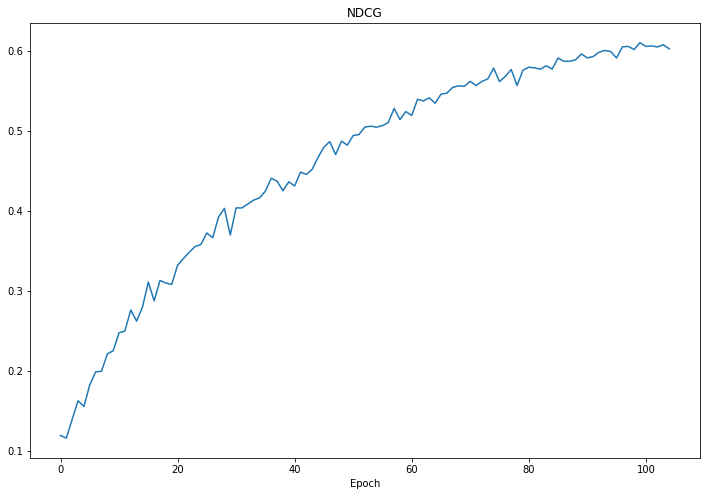

In [20]:
results_df['NDCG'].plot(figsize=(12,8), title='NDCG')